In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# 필터의 개수가 변경되는 블럭
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [3]:
# 최대 폴링층을 가지는 블럭
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,padding='same')(x)
residual = layers.Conv2D(64,1,strides=2)(residual)
x = layers.add([x,residual])

In [4]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

In [5]:
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x =  layers.GlobalMaxPool2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs = outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_6[0][0]']               
                                                                                              

- 배치 정규화
- 깊이별 분리 합성곱
- Xception 유사 모델에 모두 적용

In [6]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From: https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:04<00:00, 190MB/s]


'dogs-vs-cats.zip'

In [7]:
# import zipfile
# zipfile.ZipFile('./dogs-vs-cats.zip').extractall()
# zipfile.ZipFile('./train.zip').extractall()

In [8]:
!unzip -qq 'dogs-vs-cats.zip'
!unzip -qq 'train.zip'

In [9]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

# GPU 사용 했음에도 약 1시간걸림 주의
# ** epochs를 줄여서 해보기

Epoch 1/100
63/63 [==============================] - 42s 464ms/step - loss: 0.7018 - accuracy: 0.5790 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 2/100
63/63 [==============================] - 29s 449ms/step - loss: 0.6636 - accuracy: 0.6030 - val_loss: 0.6925 - val_accuracy: 0.5210
Epoch 3/100
63/63 [==============================] - 29s 453ms/step - loss: 0.6370 - accuracy: 0.6350 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 30s 458ms/step - loss: 0.6286 - accuracy: 0.6445 - val_loss: 0.7344 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 29s 457ms/step - loss: 0.5989 - accuracy: 0.6920 - val_loss: 0.8074 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 29s 455ms/step - loss: 0.5865 - accuracy: 0.6920 - val_loss: 0.7719 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 30s 465ms/step - loss: 0.5648 - accuracy: 0.7015 - val_loss: 0.8293 - val_accuracy:

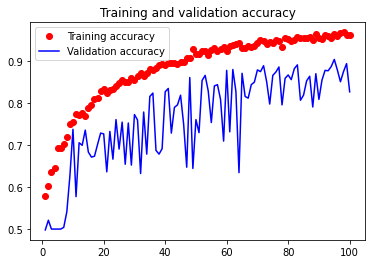

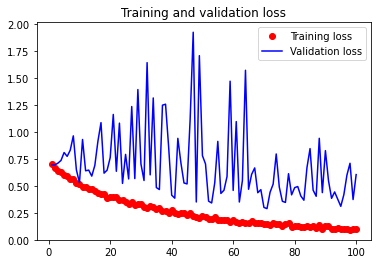

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()